In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import BayesianGaussianMixture

In [198]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [199]:
train_df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [200]:
test_df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [201]:
train_df.shape

(17176, 14)

In [202]:
test_df.shape

(8576, 13)

# Column meaning

|Column | Meaning
|---|---|
|tripid  |Trip ID|
|additional_fare |  Additional fare charged in rupees|
|duration| Duration of the trip in seconds from trip-start to trip-end|
|meter_waiting| Duration in seconds indicating the total time the vehicle was immobile from trip-start to trip-end|
|meter_waiting_fare| Fare for the time the vehicle was stopped within trip-start to trip-end duration. This may be due to traffic or other reason ex: stop at supermarket|
|meter_waiting_till_pickup| Time between trip-accept to trip-start|
|pickup_time| Date and time at pickup|
|drop_time| Date and time at drop off|
|pick_lat| Pickup latitude|
|pick_lon| Pickup longitude|
|drop_lat| Drop latitude|
|drop_lon| Drop longitudefare Trip fare|
|label| Label indicating if it is a correct or incorrect trip fare|


## Check missing values

In [203]:
train_df.isna().any()

tripid                       False
additional_fare               True
duration                      True
meter_waiting                 True
meter_waiting_fare            True
meter_waiting_till_pickup     True
pickup_time                  False
drop_time                    False
pick_lat                     False
pick_lon                     False
drop_lat                     False
drop_lon                     False
fare                          True
label                        False
dtype: bool

In [204]:
train_df.isna().sum()

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

Missing values for additional_fare, duration, meter_waiting, meter_waiting_fare, meter_waiting_till_pickup are in the same row. Probably intentially dropped?

In [205]:
train_df[train_df['additional_fare'].isna() & train_df['duration'].isna() & train_df['meter_waiting'].isna() & train_df['meter_waiting'].isna() & train_df['meter_waiting_fare'].isna() & train_df['meter_waiting_till_pickup'].isna()]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
31,189164831,NaN,NaN,NaN,NaN,NaN,11/1/2019 9:17,11/1/2019 9:25,7.27586,80.6136,7.28810,80.6319,NaN,incorrect
91,189231599,NaN,NaN,NaN,NaN,NaN,11/1/2019 14:48,11/1/2019 15:03,7.04783,79.8973,7.05307,79.9188,196.50,incorrect
253,189393356,NaN,NaN,NaN,NaN,NaN,11/2/2019 13:29,11/2/2019 13:55,7.21158,79.8401,7.20136,79.8455,188.71,incorrect
811,190066074,NaN,NaN,NaN,NaN,NaN,11/5/2019 16:49,11/5/2019 17:01,7.48201,80.3580,7.50463,80.3510,NaN,incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16994,213449192,NaN,NaN,NaN,NaN,NaN,1/30/2020 22:52,1/30/2020 23:05,6.88183,79.8577,6.84729,79.8734,NaN,incorrect
17033,213510465,NaN,NaN,NaN,NaN,NaN,1/31/2020 10:03,1/31/2020 10:04,6.92600,79.8681,6.92596,79.8679,NaN,incorrect
17052,213538831,NaN,NaN,NaN,NaN,NaN,1/31/2020 11:53,1/31/2020 13:09,6.70807,79.9125,6.70815,79.9127,NaN,incorrect
17123,213674502,NaN,NaN,NaN,NaN,NaN,1/31/2020 16:46,1/31/2020 17:59,6.87969,79.8597,6.97458,79.9380,NaN,incorrect


Most of the missing values for fair have missing values for other missing column however few have values for other missing columns 

In [206]:
train_df[train_df['additional_fare'].isna() & train_df['duration'].isna() & train_df['meter_waiting'].isna() & train_df['meter_waiting'].isna() & train_df['meter_waiting_fare'].isna() & train_df['meter_waiting_till_pickup'].isna() & train_df['fare'].isna()]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
31,189164831,NaN,NaN,NaN,NaN,NaN,11/1/2019 9:17,11/1/2019 9:25,7.27586,80.6136,7.28810,80.6319,NaN,incorrect
811,190066074,NaN,NaN,NaN,NaN,NaN,11/5/2019 16:49,11/5/2019 17:01,7.48201,80.3580,7.50463,80.3510,NaN,incorrect
861,190111701,NaN,NaN,NaN,NaN,NaN,11/5/2019 21:13,11/5/2019 21:15,7.03357,79.9238,7.03365,79.9238,NaN,incorrect
894,190144719,NaN,NaN,NaN,NaN,NaN,11/6/2019 7:39,11/6/2019 7:40,6.87554,79.8973,6.87573,79.8965,NaN,incorrect
1024,190243365,NaN,NaN,NaN,NaN,NaN,11/6/2019 17:23,11/6/2019 17:47,6.90195,79.8942,6.89726,79.8698,NaN,incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16994,213449192,NaN,NaN,NaN,NaN,NaN,1/30/2020 22:52,1/30/2020 23:05,6.88183,79.8577,6.84729,79.8734,NaN,incorrect
17033,213510465,NaN,NaN,NaN,NaN,NaN,1/31/2020 10:03,1/31/2020 10:04,6.92600,79.8681,6.92596,79.8679,NaN,incorrect
17052,213538831,NaN,NaN,NaN,NaN,NaN,1/31/2020 11:53,1/31/2020 13:09,6.70807,79.9125,6.70815,79.9127,NaN,incorrect
17123,213674502,NaN,NaN,NaN,NaN,NaN,1/31/2020 16:46,1/31/2020 17:59,6.87969,79.8597,6.97458,79.9380,NaN,incorrect


In [207]:
train_df[~(train_df['additional_fare'].isna() & train_df['duration'].isna() & train_df['meter_waiting'].isna() & train_df['meter_waiting'].isna() & train_df['meter_waiting_fare'].isna() & train_df['meter_waiting_till_pickup'].isna()) & train_df['fare'].isna()]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
20,189157607,10.5,2956.0,1686.0,97.450800,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,incorrect
30,189164806,10.5,3549.0,2689.0,146.985400,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,incorrect
1924,191263471,5.0,39.0,19.0,1.107700,0.0,11/11/2019 11:00,11/11/2019 11:09,6.93940,79.8756,6.93693,79.8641,NaN,incorrect
2700,192182656,5.0,23.0,23.0,1.340900,0.0,11/15/2019 14:31,11/15/2019 14:35,6.87287,79.8908,6.87959,79.8911,NaN,incorrect
11952,206984071,10.5,1585.0,833.0,48.147400,169.0,1/4/2020 15:05,1/4/2020 15:18,6.91742,79.8550,6.93338,79.8548,NaN,incorrect
13544,209203396,10.5,2423.0,1905.0,110.162896,23.0,1/13/2020 13:03,1/13/2020 13:15,6.91742,79.8550,6.92723,79.8452,NaN,incorrect


In [208]:
test_df.isna().any()

tripid                       False
additional_fare              False
duration                     False
meter_waiting                False
meter_waiting_fare           False
meter_waiting_till_pickup    False
pickup_time                  False
drop_time                    False
pick_lat                     False
pick_lon                     False
drop_lat                     False
drop_lon                     False
fare                         False
dtype: bool

# Label distribution

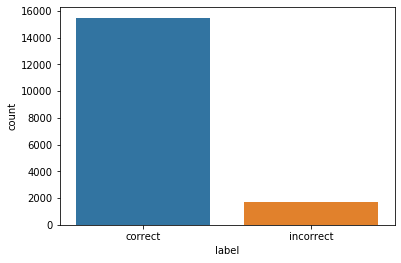

In [209]:
sns.countplot(x='label', data=train_df)

### Distribution for missing values

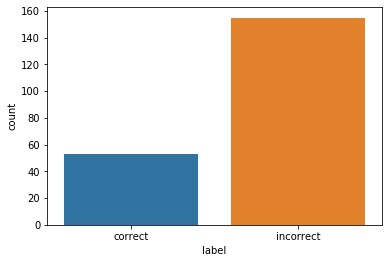

In [210]:
sns.countplot(x='label', data=train_df[train_df['additional_fare'].isna() | train_df['fare'].isna()])

### Distribution after dropping missing values

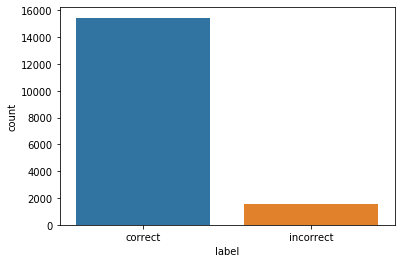

In [211]:
sns.countplot(x='label', data=train_df.dropna())

# Check for data leaks

In [212]:
pd.merge(train_df, test_df, on=['tripid'],how='inner')

,tripid,additional_fare_x,duration_x,meter_waiting_x,meter_waiting_fare_x,meter_waiting_till_pickup_x,pickup_time_x,drop_time_x,pick_lat_x,pick_lon_x,...,meter_waiting_y,meter_waiting_fare_y,meter_waiting_till_pickup_y,pickup_time_y,drop_time_y,pick_lat_y,pick_lon_y,drop_lat_y,drop_lon_y,fare_y


# Feature extraction functions

In [213]:
def extract_time(feature='date'):
    def f(time_stamp): 
        date,time = time_stamp.strip().split()
        date = list(map(int, date.split('/')))
        time = list(map(int, time.split(':')))
        if feature == 'date':
            return date[1]
        if feature == 'month':
            return date[0]
        if feature == 'year':
            return date[2]
        if feature == 'hour':
            return time[0]
        if feature == 'minute':
            return time[1]
    return f
        

In [214]:
def get_combined_dataset(cols, train=train_df, test=test_df):
    tmp_1 = train.loc[:,cols]
    tmp_1['dataset'] = 'train'

    tmp_2 = test.loc[:,cols]
    tmp_2['dataset'] = 'test'
    return tmp_1.append(tmp_2)
    

# Data distribution

In [215]:
data = train_df.dropna().drop(['tripid'],axis=1)
data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
5,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct


### Extract time data

In [216]:
data['pickup_month'] = data['pickup_time'].map(extract_time('month'))
data['pickup_date'] = data['pickup_time'].map(extract_time('date'))
data['pickup_year'] = data['pickup_time'].map(extract_time('year'))
data['pickup_hour'] = data['pickup_time'].map(extract_time('hour'))
data['pickup_minute'] = data['pickup_time'].map(extract_time('minute'))

In [217]:
data['drop_month'] = data['drop_time'].map(extract_time('month'))
data['drop_date'] = data['drop_time'].map(extract_time('date'))
data['drop_year'] = data['drop_time'].map(extract_time('year'))
data['drop_hour'] = data['drop_time'].map(extract_time('hour'))
data['drop_minute'] = data['drop_time'].map(extract_time('minute'))

In [218]:
test_df['pickup_month'] = test_df['pickup_time'].map(extract_time('month'))
test_df['pickup_date'] = test_df['pickup_time'].map(extract_time('date'))
test_df['pickup_year'] = test_df['pickup_time'].map(extract_time('year'))
test_df['pickup_hour'] = test_df['pickup_time'].map(extract_time('hour'))
test_df['pickup_minute'] = test_df['pickup_time'].map(extract_time('minute'))

test_df['drop_month'] = test_df['drop_time'].map(extract_time('month'))
test_df['drop_date'] = test_df['drop_time'].map(extract_time('date'))
test_df['drop_year'] = test_df['drop_time'].map(extract_time('year'))
test_df['drop_hour'] = test_df['drop_time'].map(extract_time('hour'))
test_df['drop_minute'] = test_df['drop_time'].map(extract_time('minute'))

## Data correlations

In [219]:
data.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
count,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000
mean,13.721437,1702.836987,628.875000,32.045122,112.489510,6.965160,79.998018,6.968278,79.997108,312.657884,7.950024,15.858852,2019.339816,13.802746,29.486150,7.948845,15.859795,2019.339934,14.081978,29.411363
std,98.992493,8121.556167,8064.657846,465.564240,442.129943,0.210840,0.242832,0.380253,0.360503,606.372103,5.002891,8.844015,0.473661,4.819490,17.286925,5.003350,8.844116,0.473700,4.881727,17.381706
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,1.000000,1.000000,2019.000000,0.000000,0.000000,1.000000,1.000000,2019.000000,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,6.864830,79.870475,6.865580,79.870100,125.500000,1.000000,8.000000,2019.000000,10.000000,15.000000,1.000000,8.000000,2019.000000,11.000000,14.000000
50%,10.500000,1009.000000,123.000000,0.115600,73.000000,6.913970,79.898600,6.915940,79.899000,211.050000,11.000000,16.000000,2019.000000,14.000000,29.000000,11.000000,16.000000,2019.000000,14.000000,29.000000
75%,10.500000,1802.250000,351.000000,14.334400,144.000000,7.042698,79.956500,7.046555,79.960000,366.205000,12.000000,23.000000,2020.000000,18.000000,45.000000,12.000000,23.000000,2020.000000,18.000000,44.000000
max,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,12.000000,31.000000,2020.000000,23.000000,59.000000,12.000000,31.000000,2020.000000,23.000000,59.000000


In [220]:
data.corr()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
additional_fare,1.000000,-0.000774,0.197606,0.199606,0.002352,0.009120,0.000612,0.004642,0.001532,0.315285,-0.018937,0.005822,0.019369,-0.005048,-0.000725,-0.018928,0.005832,0.019359,-0.004706,0.000050
duration,-0.000774,1.000000,0.969788,0.968667,0.040577,-0.027081,-0.025590,-0.015969,-0.013603,0.865256,0.013207,0.009550,-0.015014,-0.005971,0.001973,0.013433,0.007509,-0.014558,-0.005450,-0.001226
meter_waiting,0.197606,0.969788,1.000000,0.999474,0.030450,-0.016167,-0.014196,-0.010114,-0.007895,0.870126,0.009214,0.005624,-0.010867,-0.009107,0.002274,0.009481,0.003692,-0.010460,-0.015286,-0.000631
meter_waiting_fare,0.199606,0.968667,0.999474,1.000000,0.029911,-0.015009,-0.012467,-0.009426,-0.006794,0.865073,0.009299,0.005059,-0.010979,-0.008464,0.002161,0.009564,0.003095,-0.010570,-0.014774,-0.000401
meter_waiting_till_pickup,0.002352,0.040577,0.030450,0.029911,1.000000,0.011381,0.016483,0.006942,0.011047,0.045468,0.009606,-0.004003,-0.010931,-0.007364,0.013528,0.009611,-0.003560,-0.010933,-0.009242,-0.006288
pick_lat,0.009120,-0.027081,-0.016167,-0.015009,0.011381,1.000000,0.519962,0.558312,0.336847,-0.024726,-0.012451,0.022048,0.014301,0.013259,0.002701,-0.012555,0.021854,0.014387,0.012932,0.002166
pick_lon,0.000612,-0.025590,-0.014196,-0.012467,0.016483,0.519962,1.000000,0.304976,0.651794,-0.035472,-0.020552,0.020257,0.021588,0.030223,0.006229,-0.020505,0.020274,0.021534,0.028430,-0.005830
drop_lat,0.004642,-0.015969,-0.010114,-0.009426,0.006942,0.558312,0.304976,1.000000,-0.420574,-0.015615,-0.002916,0.005164,0.003242,0.001190,0.004095,-0.002896,0.005115,0.003219,0.000648,0.003840
drop_lon,0.001532,-0.013603,-0.007895,-0.006794,0.011047,0.336847,0.651794,-0.420574,1.000000,-0.014981,-0.018494,0.020072,0.019860,0.038290,0.001042,-0.018486,0.020157,0.019844,0.035748,-0.008681
fare,0.315285,0.865256,0.870126,0.865073,0.045468,-0.024726,-0.035472,-0.015615,-0.014981,1.000000,0.009823,0.016378,-0.011604,-0.008746,0.002615,0.009769,0.014970,-0.011018,0.000990,-0.003342


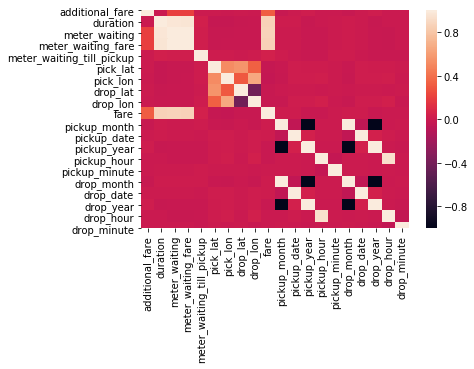

In [221]:
corr = data.corr()
# fig, ax = plt.subplots(figsize=(10,10))
# plt.xticks(range(len(corr.columns)), corr.columns)
# plt.yticks(range(len(corr.columns)), corr.columns)
# ax.matshow(corr)
sns.heatmap(corr)

## Lattitude longitude data

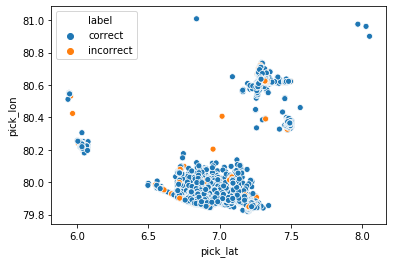

In [222]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=data,hue='label')

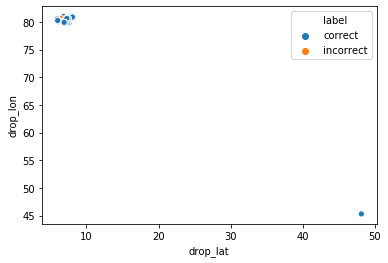

In [223]:
sns.scatterplot(x='drop_lat',y='drop_lon',data=data,hue='label')

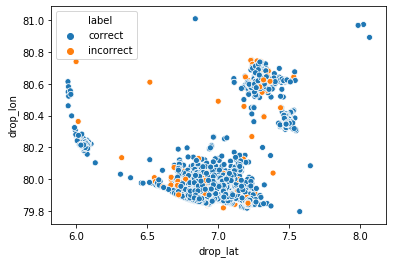

In [224]:
sns.scatterplot(x='drop_lat',y='drop_lon',data=data[data['drop_lat'] < 30],hue='label')

One coordinate seems to be an outlier

In [225]:
# data = data[data['drop_lat'] < 30]

#### Comparision of training and testing sets

In [226]:
cols = ['drop_lat', 'drop_lon', 'pick_lat', 'pick_lon']
comb_data = get_combined_dataset(cols, train=data)

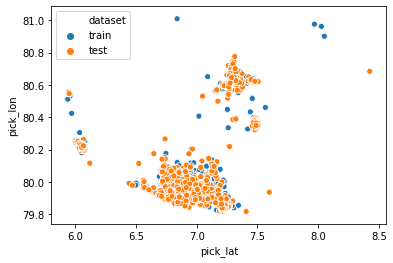

In [227]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=comb_data,hue='dataset')

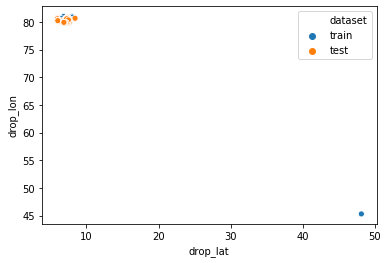

In [228]:
sns.scatterplot(x='drop_lat',y='drop_lon',data=comb_data,hue='dataset')

## Time data

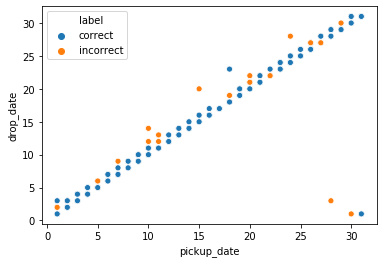

In [229]:
sns.scatterplot(x='pickup_date',y='drop_date',data=data, hue='label')

In [230]:
data[data['pickup_date'] != data['drop_date']]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,...,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
74,5.0,162747.0,162277.0,9460.749100,0.0,11/1/2019 13:35,11/3/2019 10:48,6.78440,79.8845,6.89959,...,11,1,2019,13,35,11,3,2019,10,48
176,10.5,1252.0,243.0,14.166900,119.0,11/1/2019 23:43,11/2/2019 0:04,6.91952,79.9744,6.97948,...,11,1,2019,23,43,11,2,2019,0,4
177,10.5,1239.0,877.0,0.000000,220.0,11/1/2019 23:52,11/2/2019 0:13,6.85292,80.0453,6.85101,...,11,1,2019,23,52,11,2,2019,0,13
178,10.5,2010.0,130.0,7.526629,45.0,11/1/2019 23:54,11/2/2019 0:27,7.02703,79.9561,7.03091,...,11,1,2019,23,54,11,2,2019,0,27
280,10.5,63273.0,61762.0,3481.294000,133.0,11/2/2019 15:54,11/3/2019 9:28,6.84863,79.9316,6.83766,...,11,2,2019,15,54,11,3,2019,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15817,10.5,1338.0,190.0,0.000000,8.0,1/24/2020 23:39,1/25/2020 0:01,6.91252,79.8755,6.84783,...,1,24,2020,23,39,1,25,2020,0,1
15819,10.5,2571.0,1411.0,0.000000,129.0,1/24/2020 23:57,1/25/2020 0:40,6.84536,79.9528,6.89190,...,1,24,2020,23,57,1,25,2020,0,40
16121,10.5,39729.0,38968.0,2252.350400,53.0,1/26/2020 15:25,1/27/2020 2:27,6.98752,79.8906,7.05781,...,1,26,2020,15,25,1,27,2020,2,27
16759,10.5,35579.0,34936.0,1950.114200,328.0,1/29/2020 21:37,1/30/2020 7:30,6.98096,79.8883,7.04629,...,1,29,2020,21,37,1,30,2020,7,30


In [231]:
test_df[test_df['pickup_date'] != test_df['drop_date']]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
213,213471769,10.5,2226,104,6.011200,36,2/1/2020 23:42,2/2/2020 0:20,7.21421,79.8467,...,2,1,2020,23,42,2,2,2020,0,20
362,213606719,30.5,32644,26725,1544.705000,46,2/2/2020 20:38,2/3/2020 5:42,7.29060,80.6328,...,2,2,2020,20,38,2,3,2020,5,42
572,213849903,10.5,3446,253,0.000000,38,2/3/2020 23:30,2/4/2020 0:27,6.84245,79.9100,...,2,3,2020,23,30,2,4,2020,0,27
685,213971441,10.5,88295,87704,5024.669600,24,2/4/2020 20:52,2/5/2020 21:23,6.84405,79.9321,...,2,4,2020,20,52,2,5,2020,21,23
852,214146818,10.5,64998,63991,3691.801600,313,2/5/2020 17:13,2/6/2020 11:16,6.87974,79.9415,...,2,5,2020,17,13,2,6,2020,11,16
1084,214424712,10.5,40797,38067,2200.272600,165,2/6/2020 19:27,2/7/2020 6:47,6.80447,79.9314,...,2,6,2020,19,27,2,7,2020,6,47
1119,214458527,10.5,1253,170,0.000000,137,2/6/2020 23:42,2/7/2020 0:03,6.93404,79.8433,...,2,6,2020,23,42,2,7,2020,0,3
1514,214917319,10.5,165634,164927,9475.847600,44,2/9/2020 8:09,2/11/2020 6:09,6.86683,79.9224,...,2,9,2020,8,9,2,11,2020,6,9
1662,215045861,10.5,4584,1257,36.645200,466,2/9/2020 23:02,2/10/2020 0:19,6.84642,79.9281,...,2,9,2020,23,2,2,10,2020,0,19
1773,215196870,10.5,62972,55505,3208.189000,961,2/10/2020 17:07,2/11/2020 10:37,6.71652,80.0638,...,2,10,2020,17,7,2,11,2020,10,37


There are instances of trip taking more than a single date in both test and train df

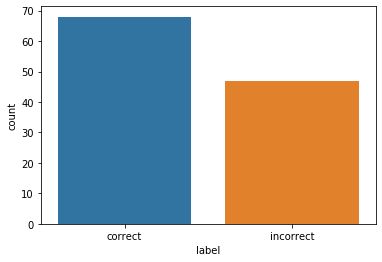

In [232]:
sns.countplot(x='label',data=data[data['pickup_date'] != data['drop_date']])

### Time location relations

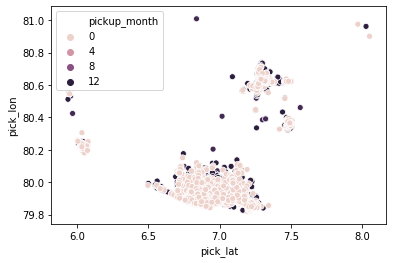

In [233]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=data,hue='pickup_month')

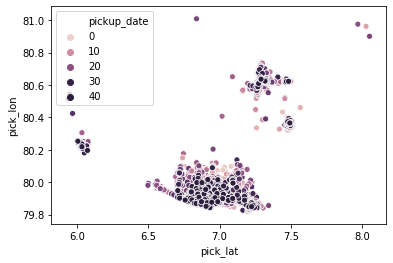

In [234]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=data,hue='pickup_date')

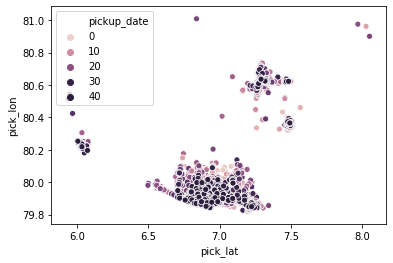

In [235]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=data,hue='pickup_date')

### Time distribution accross datasets

In [236]:
cols = ['pickup_month',
       'pickup_date', 'pickup_year', 'pickup_hour', 'pickup_minute',
       'drop_month', 'drop_date', 'drop_year', 'drop_hour', 'drop_minute']
comb_data = get_combined_dataset(cols, train=data)

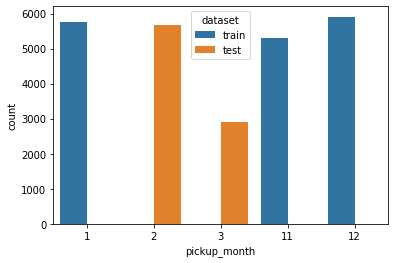

In [237]:
sns.countplot(x='pickup_month', data=comb_data, hue='dataset')

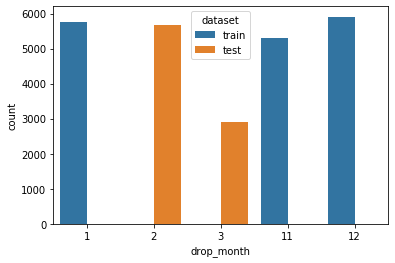

In [238]:
sns.countplot(x='drop_month', data=comb_data, hue='dataset')

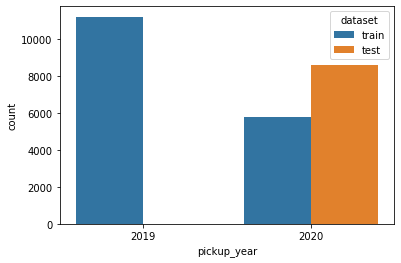

In [239]:
sns.countplot(x='pickup_year', data=comb_data, hue='dataset')

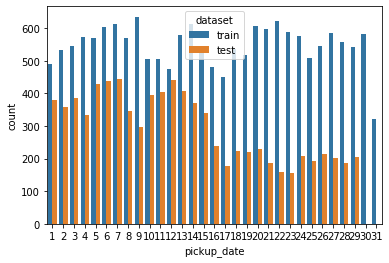

In [240]:
sns.countplot(x='pickup_date', data=comb_data, hue='dataset')

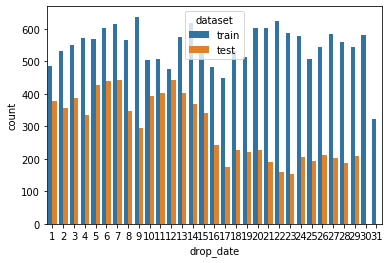

In [241]:
sns.countplot(x='drop_date', data=comb_data, hue='dataset')

## Continious value distribution

In [242]:
# sns.pairplot(data=data,hue='label')

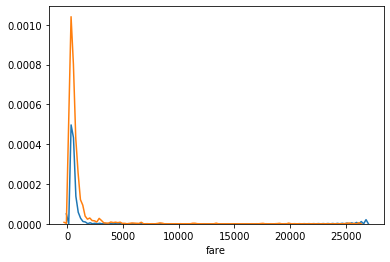

In [243]:
sns.distplot(data[data['label']=='correct']['fare'], hist=False)
sns.distplot(data[data['label']=='incorrect']['fare'], hist=False)

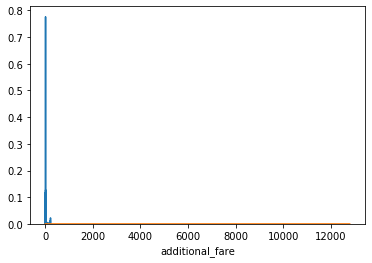

In [244]:
sns.distplot(data[data['label']=='correct']['additional_fare'], hist=False)
sns.distplot(data[data['label']=='incorrect']['additional_fare'], hist=False)

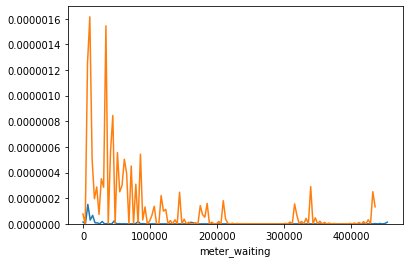

In [245]:
sns.distplot(data[data['label']=='correct']['meter_waiting'], hist=False)
sns.distplot(data[data['label']=='incorrect']['meter_waiting'], hist=False)

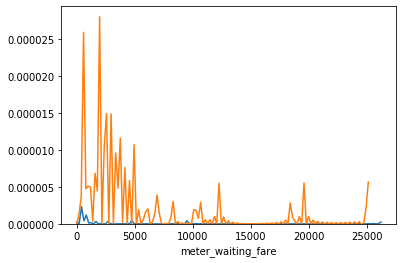

In [246]:
sns.distplot(data[data['label']=='correct']['meter_waiting_fare'], hist=False)
sns.distplot(data[data['label']=='incorrect']['meter_waiting_fare'], hist=False)

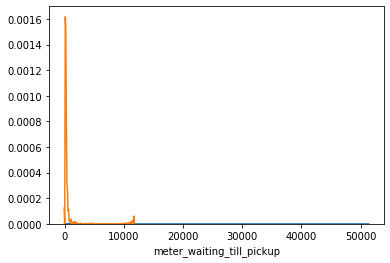

In [247]:
sns.distplot(data[data['label']=='correct']['meter_waiting_till_pickup'], hist=False)
sns.distplot(data[data['label']=='incorrect']['meter_waiting_till_pickup'], hist=False)

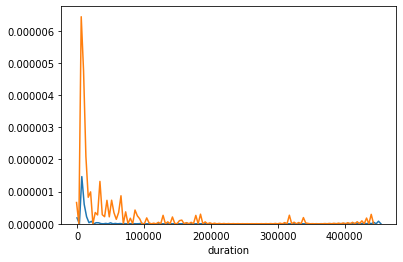

In [248]:
sns.distplot(data[data['label']=='correct']['duration'], hist=False)
sns.distplot(data[data['label']=='incorrect']['duration'], hist=False)

# Clustering lat longs

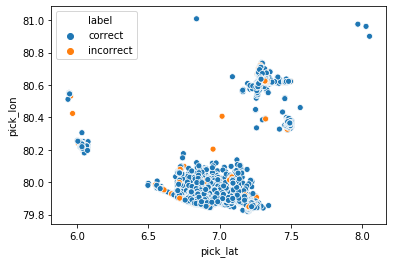

In [249]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=data,hue='label')

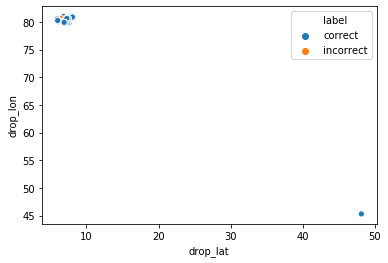

In [250]:
sns.scatterplot(x='drop_lat',y='drop_lon',data=data,hue='label')

In [251]:
cols = ['pick_lat','pick_lon']
comb_data = get_combined_dataset(cols, train=data)

In [252]:
gmm_pick = BayesianGaussianMixture(n_components=4)
gmm_pick.fit(comb_data[cols].values)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=4, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [253]:
data['pick_cluster'] = gmm_pick.predict(data[cols].values)
test_df['pick_cluster'] = gmm_pick.predict(test_df[cols].values)

In [254]:
cols = ['drop_lat','drop_lon']
comb_data = get_combined_dataset(cols, train=data)

gmm_drop = BayesianGaussianMixture(n_components=3)
gmm_drop.fit(comb_data[cols].values)

data['drop_cluster'] = gmm_drop.predict(data[cols].values)
test_df['drop_cluster'] = gmm_drop.predict(test_df[cols].values)

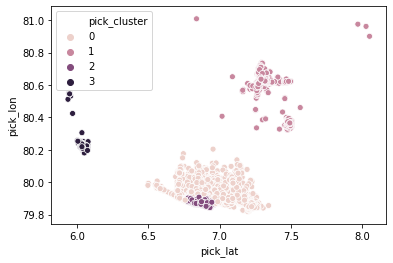

In [255]:
sns.scatterplot(x='pick_lat',y='pick_lon',data=data,hue='pick_cluster')

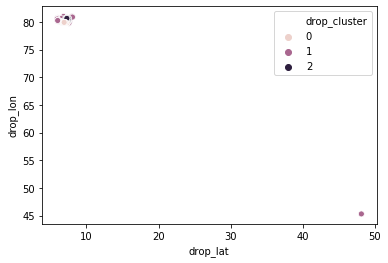

In [256]:
sns.scatterplot(x='drop_lat',y='drop_lon',data=data,hue='drop_cluster')

# Save the data frames

In [257]:
def encode_label(label):
    if label == 'correct':
        return 1
    elif label == 'incorrect':
        return 0
    else:
        return label

In [258]:
data['label'] = data['label'].map(encode_label)

In [259]:
data.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'pickup_month',
       'pickup_date', 'pickup_year', 'pickup_hour', 'pickup_minute',
       'drop_month', 'drop_date', 'drop_year', 'drop_hour', 'drop_minute',
       'pick_cluster', 'drop_cluster'],
      dtype='object')

In [263]:
columns_to_save = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare',
       'pickup_date', 'pickup_year', 'pickup_hour', 'pickup_minute',
        'drop_date', 'drop_year', 'drop_hour', 'drop_minute','pick_cluster']
data.loc[:, columns_to_save+['label']].to_csv('train_df.csv',index=False)
test_df.loc[:, columns_to_save].to_csv('test_df.csv',index=False)